### paper plots

pretty plots for final paper

In [1]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

reload(ev)
reload(utils)

Using TensorFlow backend.


<module 'autoencodeSVJ.utils' from '/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/utils.pyc'>

In [2]:
# ev.update_all_signal_evals()
# ev.get_training_info_dict('training_name')
# ev.check_training('training_name')
# utils.load_summary(utils.summary_by_name('hlf_eflow3_8_v36'))

In [47]:
aucs = ev.load_auc_table()
aucs_old = ev.load_auc_table('TEST')
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

In [122]:
def get_signal_auc_df(aucs, n_avg=1, do_max=False):
    lp = None
    if do_max:
        lp = aucs.max(axis=1).to_frame().reset_index().rename(columns={0:'auc'})
    else:
        lp = aucs.iloc[
            :,np.argsort(aucs.mean()).values[::-1][:n_avg]
        ].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})

    lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
    lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
    
    lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu',  'auc')

    return lp
                                                
def plot_signal_aucs_from_lp(lp, n_avg=1, do_max=False, title=None, fac=1.5, barlabel=None):

    plt.figure(figsize=(1.1*fac*6.9,1.1*fac*6))

    plt.imshow(lp)
    if barlabel == None:
        barlabel='AUC value'
    cb = plt.colorbar()
    cb.set_label(label=barlabel, fontsize=18*fac)

    plt.xticks(np.arange(0,5,1), map(lambda x: '{:.2f}'.format(x), np.unique(lp.columns)))
    plt.yticks(np.arange(0,6,1), np.unique(lp.index))
    
    if title is not None:
        plt.title(title, fontsize=fac*25)
    elif do_max:
        plt.title('Best AUCs (for any autoencoder)', fontsize=fac*25)
    elif n_avg < 2:
        plt.title('Signal AUCs (best autoencoder)', fontsize=fac*25)
    else:
        plt.title('Average Signal AUCs (best {} models)'.format(n_avg), fontsize=fac*25)
    plt.ylabel(r'$M_{Z^\prime}$ (GeV)', fontsize=fac*20)
    plt.xlabel(r'$r_{inv}$', fontsize=fac*20)
    plt.xticks(fontsize=18*fac)
    plt.yticks(fontsize=18*fac)

    for mi,(mass,row) in enumerate(lp.iterrows()):
        for ni,(nu,auc) in enumerate(row.iteritems()):
            plt.text(ni, mi, '{:.3f}'.format(auc), ha="center", va="center", color="w", fontsize=18*fac)

    return plt.gca()
                                                
def plot_signal_aucs(aucs, n_avg=1, do_max=False, title=None, fac=1.5):
    lp = get_signal_auc_df(aucs, n_avg, do_max)
    return lp, plot_signal_aucs_from_lp(lp, n_avg, do_max, title, fac)
                                                
                                                

In [123]:
diff = (bdts - best) / ((bdts + best)/2.)*100.

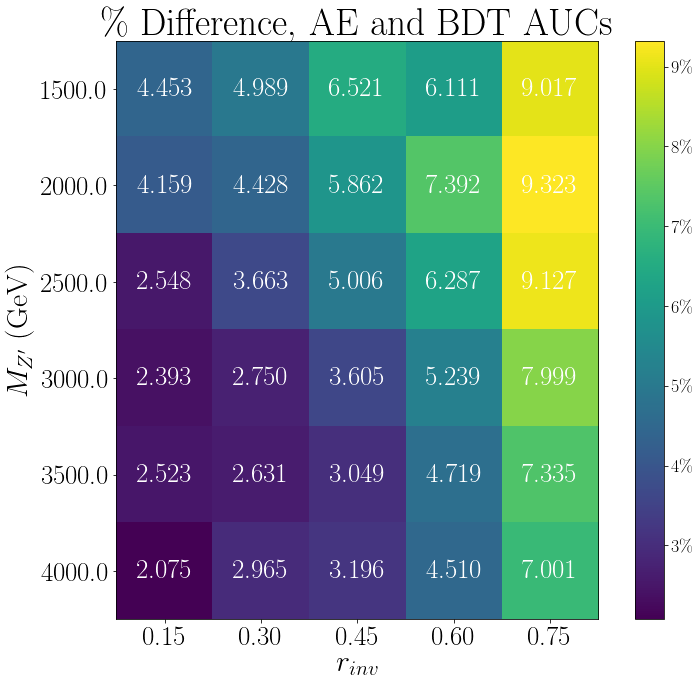

In [156]:
ax = plot_signal_aucs_from_lp(diff, title='\% Difference, AE and BDT AUCs', barlabel='')
ax.images[-1].colorbar.remove()
cb = plt.colorbar(ticks=range(2,10))
cb.ax.set_yticklabels(['{}\%'.format(x) for x in range(3,10)])

plt.tight_layout()

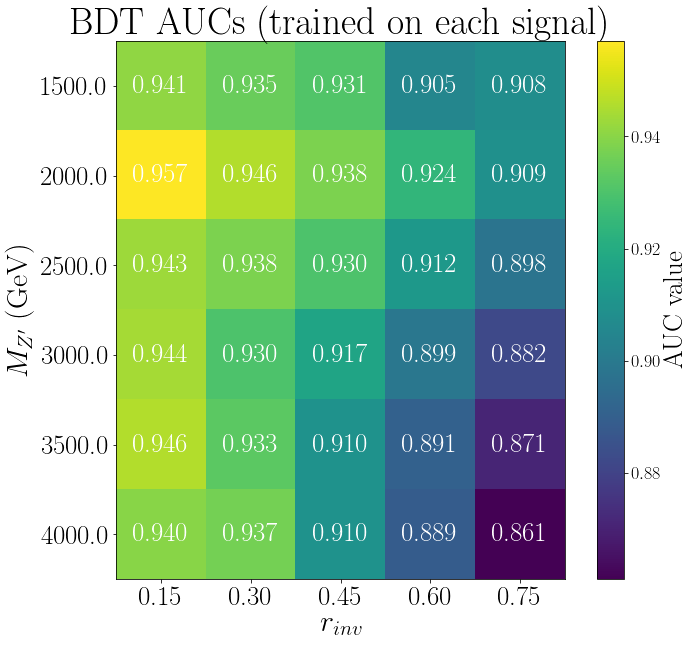

In [157]:
plot_signal_aucs_from_lp(bdts, title='BDT AUCs (trained on each signal)')

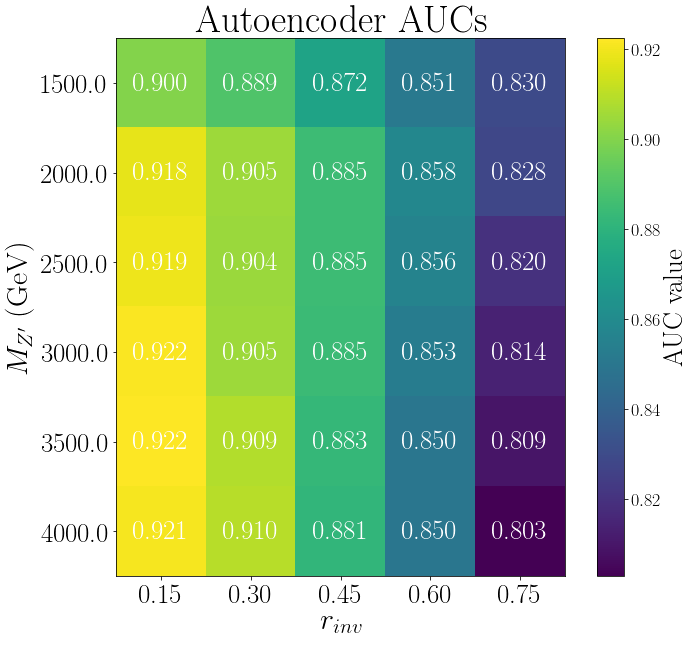

In [158]:
best = plot_signal_aucs(aucs, title='Autoencoder AUCs')

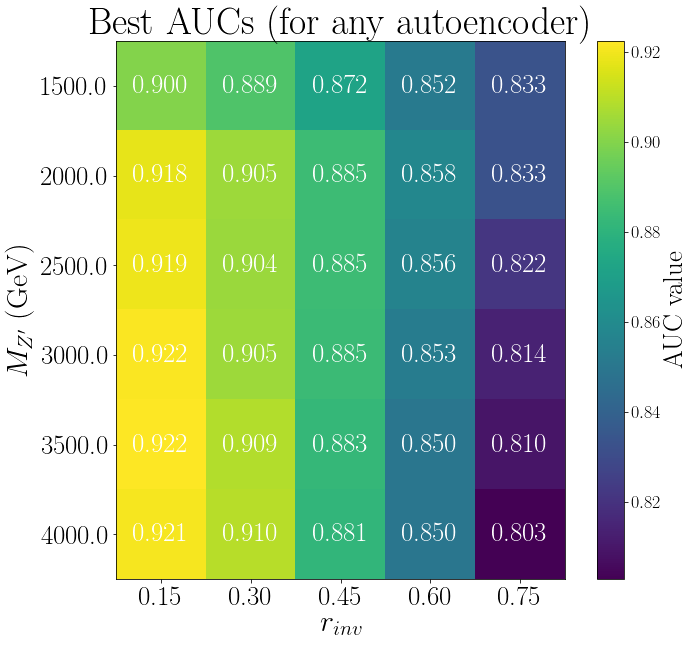

In [159]:
overall = plot_signal_aucs(aucs, do_max=True)

In [160]:
def histby(aucs, category, bins=20, lines=False, stacked=False, histtype='step', alpha=1, cat_name=None):
    if cat_name is None:
        cat_name = category
    tab = aucs.reset_index()
    cats = ['mass', 'nu']
    tab['mass'] = tab.mass_nu_ratio.map(lambda x: x[0])
    tab['nu'] = tab.mass_nu_ratio.map(lambda x: x[1])
    tab = tab.drop('mass_nu_ratio', axis=1)
    
    tab = tab.drop([m for m in cats if m != category], axis=1)
    groups = tab.groupby(category).apply(lambda x: x.values.flatten())
    
    
    rng = aucs.values.min(), aucs.values.max() 
    if stacked:
        histtype=None
    
    if lines:
        vals = np.linspace(rng[0], rng[1], bins + 1)
        cnts = np.asarray([np.histogram(g, bins=vals)[0] for g in np.asarray(groups.values)])
        
        x = vals[:-1] + np.diff(vals)/2
        ys = np.asarray(cnts)
        for y,label in zip(ys, groups.index):
            plt.plot(x, y, label=label)
        plt.legend(title=cat_name)
        
        return plt.gca()

    rets = plt.hist(np.asarray(groups.values), bins=bins, range=rng, stacked=stacked, alpha=alpha, histtype=histtype, label=[val for val in groups.index])
    plt.legend(title=cat_name)
    return plt.gca()


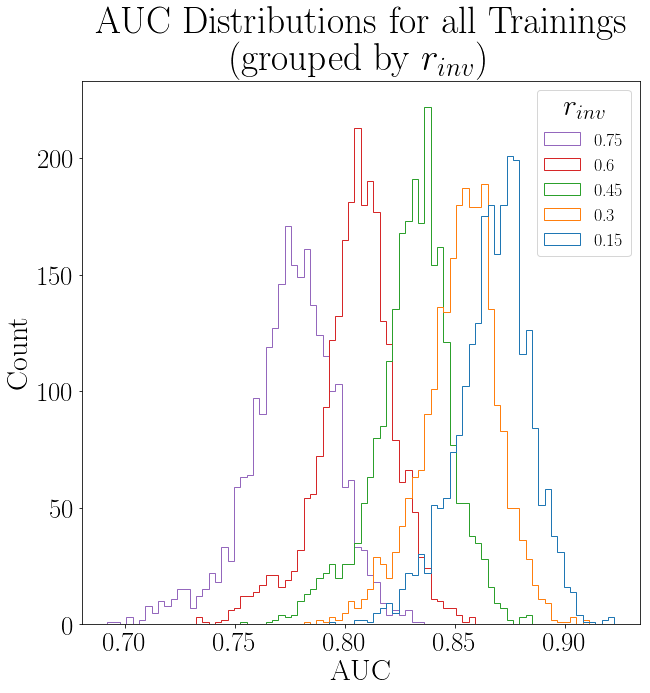

In [178]:
fac = 1.5
ax = histby(aucs, 'nu', lines=False, alpha=1, histtype='step', bins=80, cat_name='$r_{inv}$')
lg = plt.legend(fontsize=12*fac, title=r'$r_{inv}$')
lg.get_title().set_fontsize(20*fac) 
plt.title('AUC Distributions for all Trainings\n(grouped by $r_{inv}$)', fontsize=25*fac)
plt.ylabel('Count', fontsize=20*fac)
plt.xlabel('AUC', fontsize=20*fac)
plt.xticks(fontsize=18*fac)
plt.yticks(fontsize=18*fac)
plt.show()

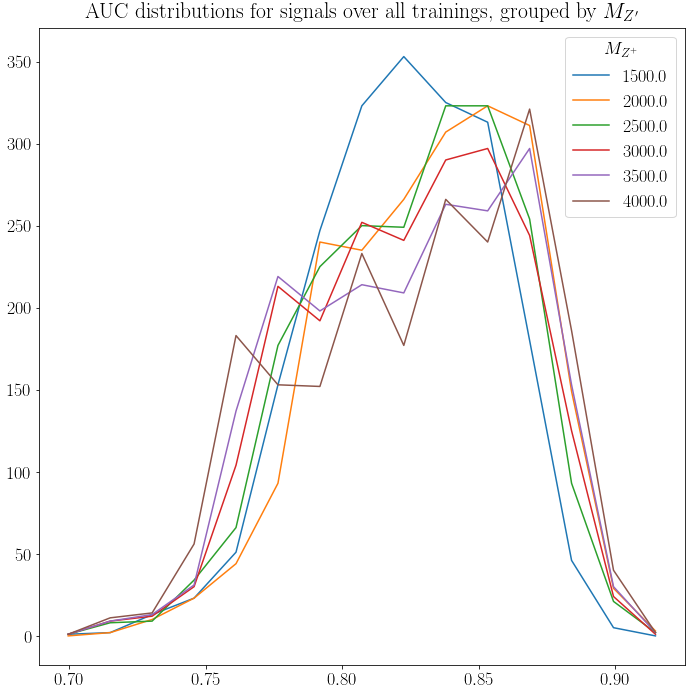

In [147]:
ax = histby(aucs, 'mass', lines=True, alpha=1, histtype='step', bins=15, cat_name='$M_{Z^+}$')
plt.title('AUC distributions for signals over all trainings, grouped by $M_{Z^\prime}$')
plt.show()

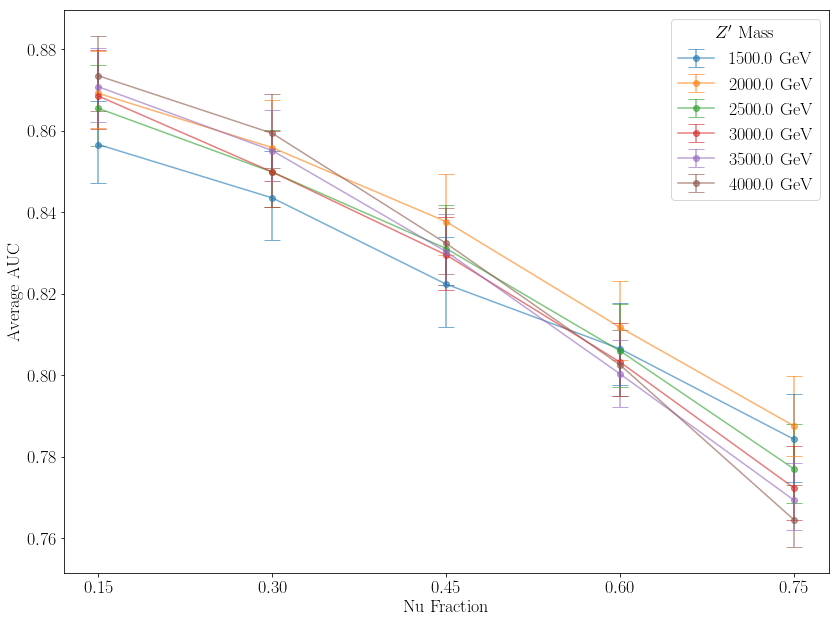

In [148]:
import scipy.stats

def plot_nu_vs_aucs(aucs, n=None):

    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values

    
    plt.figure(figsize=(12,9))
    
    for mass in sorted(set(masses)):
        idx = masses == mass
        
        plt.errorbar(nus[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{} GeV'.format(mass), capsize=8.0, alpha=0.6)
        
    
    plt.xlabel('Nu Fraction')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(nus))
    plt.legend(title=r'$Z^{\prime}$ Mass')
    plt.title('')
    plt.show()
#     return means, lower, upper
    
plot_nu_vs_aucs(aucs)

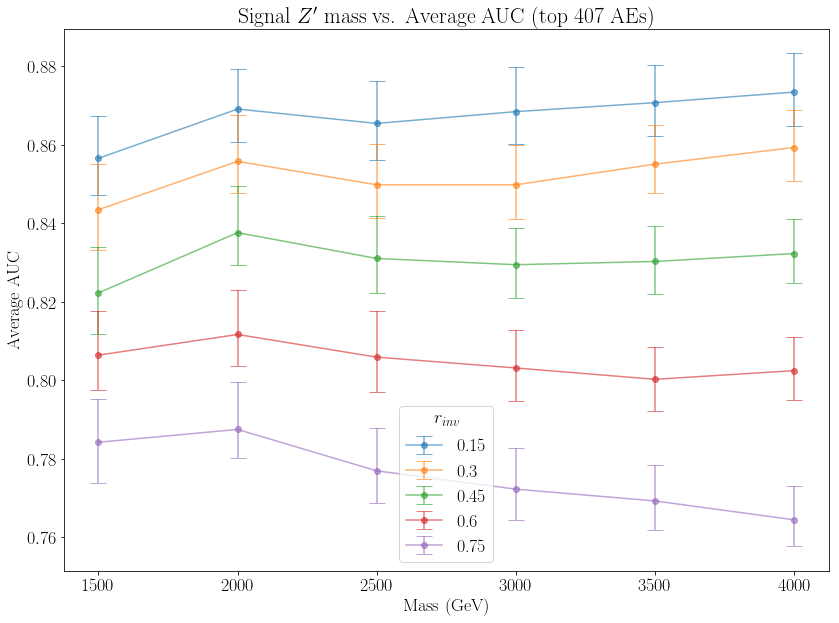

In [149]:
def plot_mass_vs_aucs(aucs, n=None):
    
    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values
    
    plt.figure(figsize=(12,9))
    
    for nu in sorted(set(nus)):
        idx = nus == nu
        plt.errorbar(masses[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{}'.format(nu), capsize=8.0, alpha=0.6)
        
    plt.xlabel('Mass (GeV)')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(masses))
    plt.legend(title=r'$r_{inv}$')
    plt.title('Signal $Z^\prime$ mass vs. Average AUC (top {} AEs)'.format(n))
    plt.tight_layout()
    plt.show()
    
plot_mass_vs_aucs(aucs)

# important
`data_holder` basically loads all signal data into memory at once, while `auc_getter` gets and generates errors, reconstructed data, and normalized data on a gievn training run. Both of these things are critical to the later plotting

In [179]:
eflow_base = 3

dholder = ev.data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*')}
)

dholder.load()
dists = {v.name: v for v in dholder.get('data')}

# signal = utils.data_table(pd.concat([v.df for v in dists.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
qcd = dists['qcd']

found 31 datasets


In [180]:
dists_subset = [v for v in dists.values() if v.name.startswith('Zprime')]
size = min(map(len, dists_subset))
signal = utils.data_table(pd.concat([v.df.iloc[:size] for v in dists_subset]), name='Z^+ Dark (Average)')

In [181]:
signal_combined = pd.concat([pd.concat([v.df, pd.Series(np.repeat(k, len(v)), name='key')], axis=1) for k,v in dists.items() if k.startswith('Zprime')])

In [182]:
sc = signal_combined

sc['mass'] = sc.key.apply(lambda x: int(x.split('_')[1].rstrip('GeV')))
sc['nu'] = sc.key.apply(lambda x: float(x.split('_')[-1])/100.)
sc.head()

,Eta,Phi,Pt,M,ChargedFraction,PTD,Axis2,eflow 1,eflow 2,eflow 3,...,eflow 6,eflow 7,eflow 8,eflow 9,eflow 10,eflow 11,eflow 12,key,mass,nu
0,0.045230,-2.963542,1060.937012,72.560196,0.542857,0.422861,0.012878,0.109822,0.043440,0.026606,...,0.005165,0.013676,0.004245,0.012061,0.004771,0.002950,0.001325,Zprime_1500GeV_075,1500,0.75
1,-0.517251,0.734206,218.460312,22.048283,0.419355,0.235611,0.058614,0.267471,0.136899,0.091385,...,0.036999,0.050795,0.032694,0.071541,0.036616,0.026557,0.019135,Zprime_1500GeV_075,1500,0.75
2,0.747401,-1.752697,764.918213,111.881714,0.438596,0.225167,0.053749,0.201216,0.106203,0.070189,...,0.020981,0.037083,0.018470,0.040488,0.021370,0.014068,0.008147,Zprime_1500GeV_075,1500,0.75
3,0.239115,0.777392,413.002228,26.284382,0.370370,0.298932,0.029016,0.178803,0.086328,0.055347,...,0.016149,0.029420,0.013739,0.031970,0.015436,0.010216,0.005716,Zprime_1500GeV_075,1500,0.75
4,1.403882,1.920689,681.028625,48.152981,0.464286,0.605886,0.007971,0.116954,0.062411,0.040772,...,0.007477,0.020941,0.006304,0.013678,0.007299,0.004326,0.001600,Zprime_1500GeV_075,1500,0.75


In [183]:
# signals = dists.copy()
# del signals['qcd']
# to_nu = {k: float(k.split('_')[-1])/100. for k in signals.keys()}

# col = 'eflow 1'
# bins = 100

# rng = signal[col].min(), signal[col].max()

# hists = {}
# for name in signals:
#     nu = to_nu[name]
#     cnts, edges = np.histogram(signals[name], range=rng, bins=bins)

#     if nu not in hists:
#         hists[nu] = np.zeros(cnts.shape)
#     hists[nu] += cnts
    
# for nu,val in hists.items():
#     plt.step([edges[0]] + list(edges), [0] + list(val) + [val[-1]], label=nu, where='post')

# plt.hist(qcd[col], bins=bins, range=rng, histtype='step', label='QCD')
# plt.legend()

In [315]:
tf.reset_default_graph()
agetter = ev.auc_getter('hlf_eflow3_8_v36', times=True)
norm, errors, recon = agetter.get_errs_recon(dholder)
aucs_ = agetter.get_aucs(errors)
fmt = agetter.auc_metric(aucs_)

signal_recon = utils.data_table(pd.concat([v.df.iloc[:size] for v in recon.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average) pred')
signal_norm = utils.data_table(pd.concat([v.df.iloc[:size] for v in norm.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
signal_err = utils.data_table(pd.concat([v.df.iloc[:size] for v in errors.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_8_v36.summary'
:: TIME: init executed in 0.62 s
:: TIME: test dataset executed in 0.07 s
train_shell :: using saved model
:: TIME: recon gen executed in 16.98 s
:: TIME: auc grab executed in 0.65 s


In [187]:
styles = {
    'Z': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'Z',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
        'range': (0., 2000.),
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
        'range': (0., 500.)
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
        'range': (0, 0.2)
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20

eflow_ranges = {
    1: (0,0.6),
    2: (0,0.5),
    3: (0,0.4),
    4: (0,0.4),
    5: (0,0.25),
    6: (0,0.15),
    7: (0,0.2),
    8: (0,0.15),
    9: (0,0.3),
    10: (0,0.2),
    11: (0,0.15),
    12: (0,0.15)
}

for num,rng in eflow_ranges.items():
    var_styles['eflow {}'.format(num)]['range'] = rng

### Pre-use histograms

Thing to convert data into column-based shit:

In [188]:
from collections import OrderedDict

def converter(toplot): 
    colsets = [tuple(x.columns) for x in toplot.values()]
    assert(len(set(colsets)) == 1)
    var = colsets[0]

    names = sorted(toplot.keys())

    out = OrderedDict()
    for name in names:
        for v in var:
            if v not in out:
                out[v] = OrderedDict()
            out[v][name] = toplot[name][v]

    return out

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


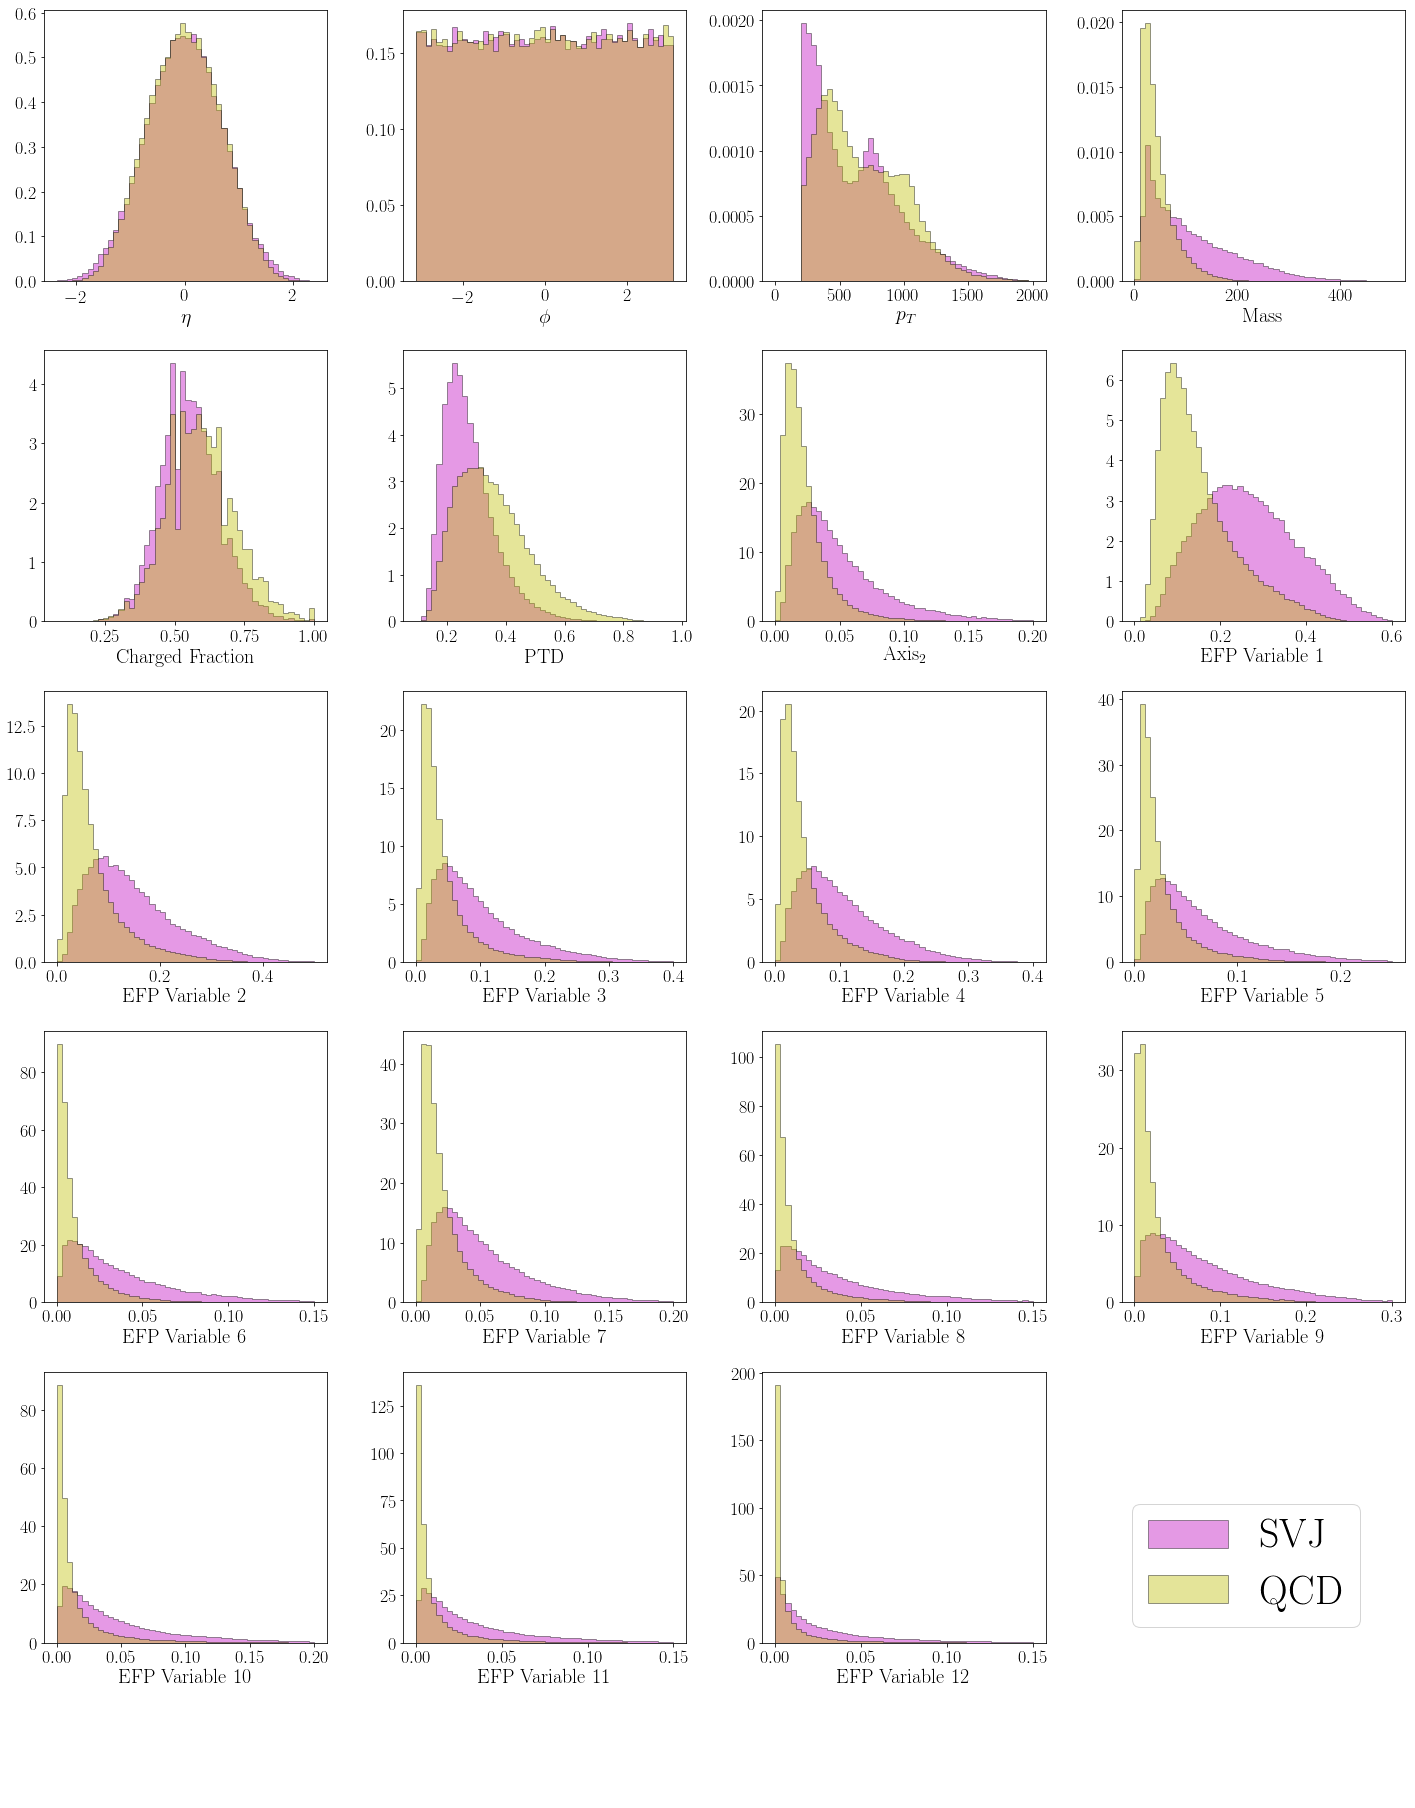

In [189]:
data = converter({'Z': signal, 'qcd': qcd})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.


fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins
i = 0
for d,v in data.items():
    var_style = var_styles[d].copy()

    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)


        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.8, 0.1), fontsize=40)
for x in axs[i:]:
    f.delaxes(x)


### Post-all

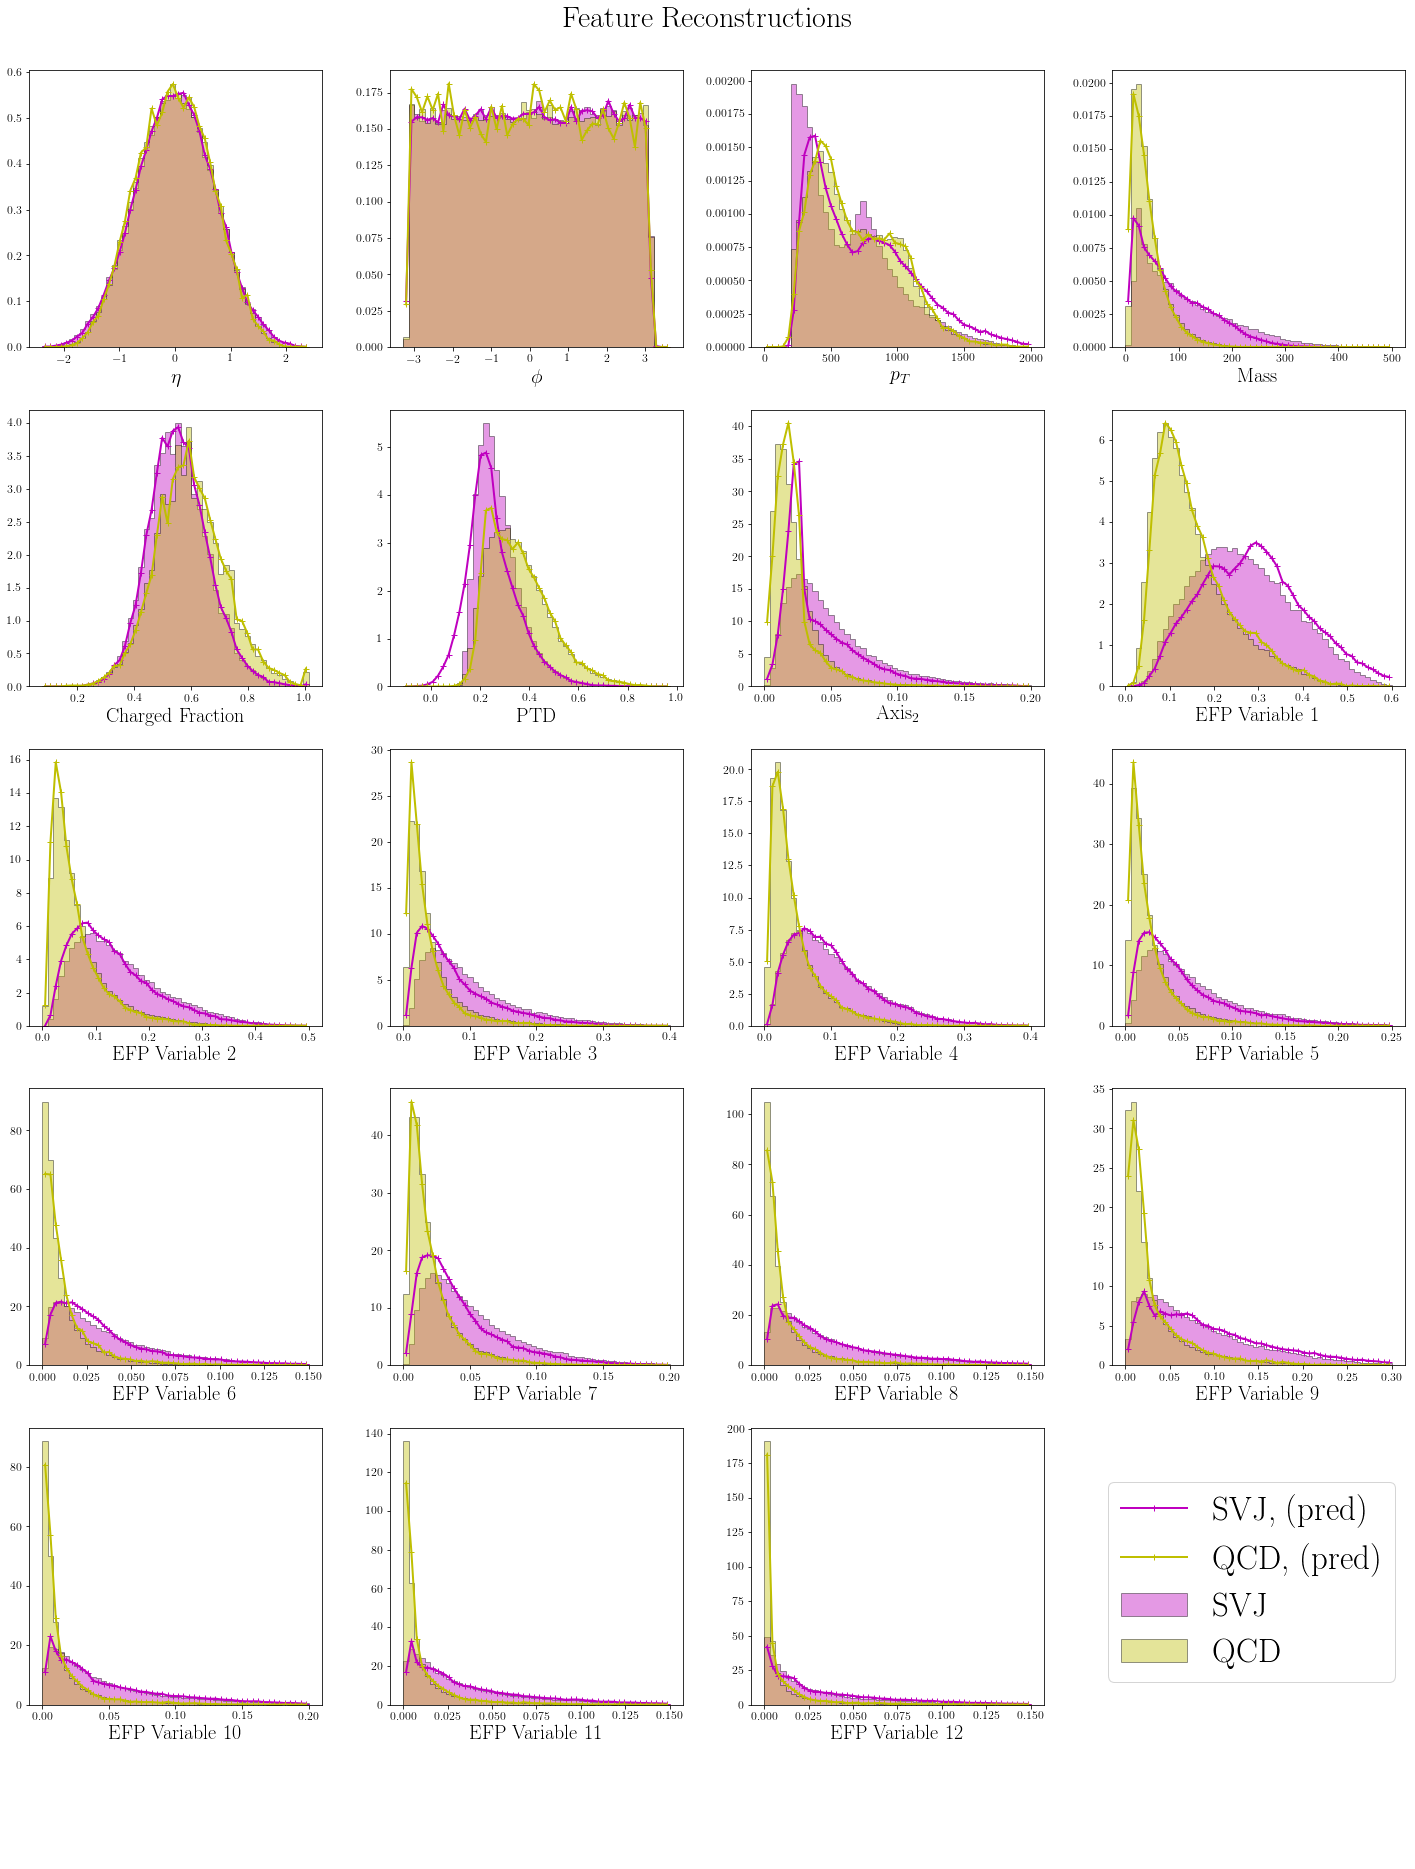

In [190]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': dists['qcd']
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

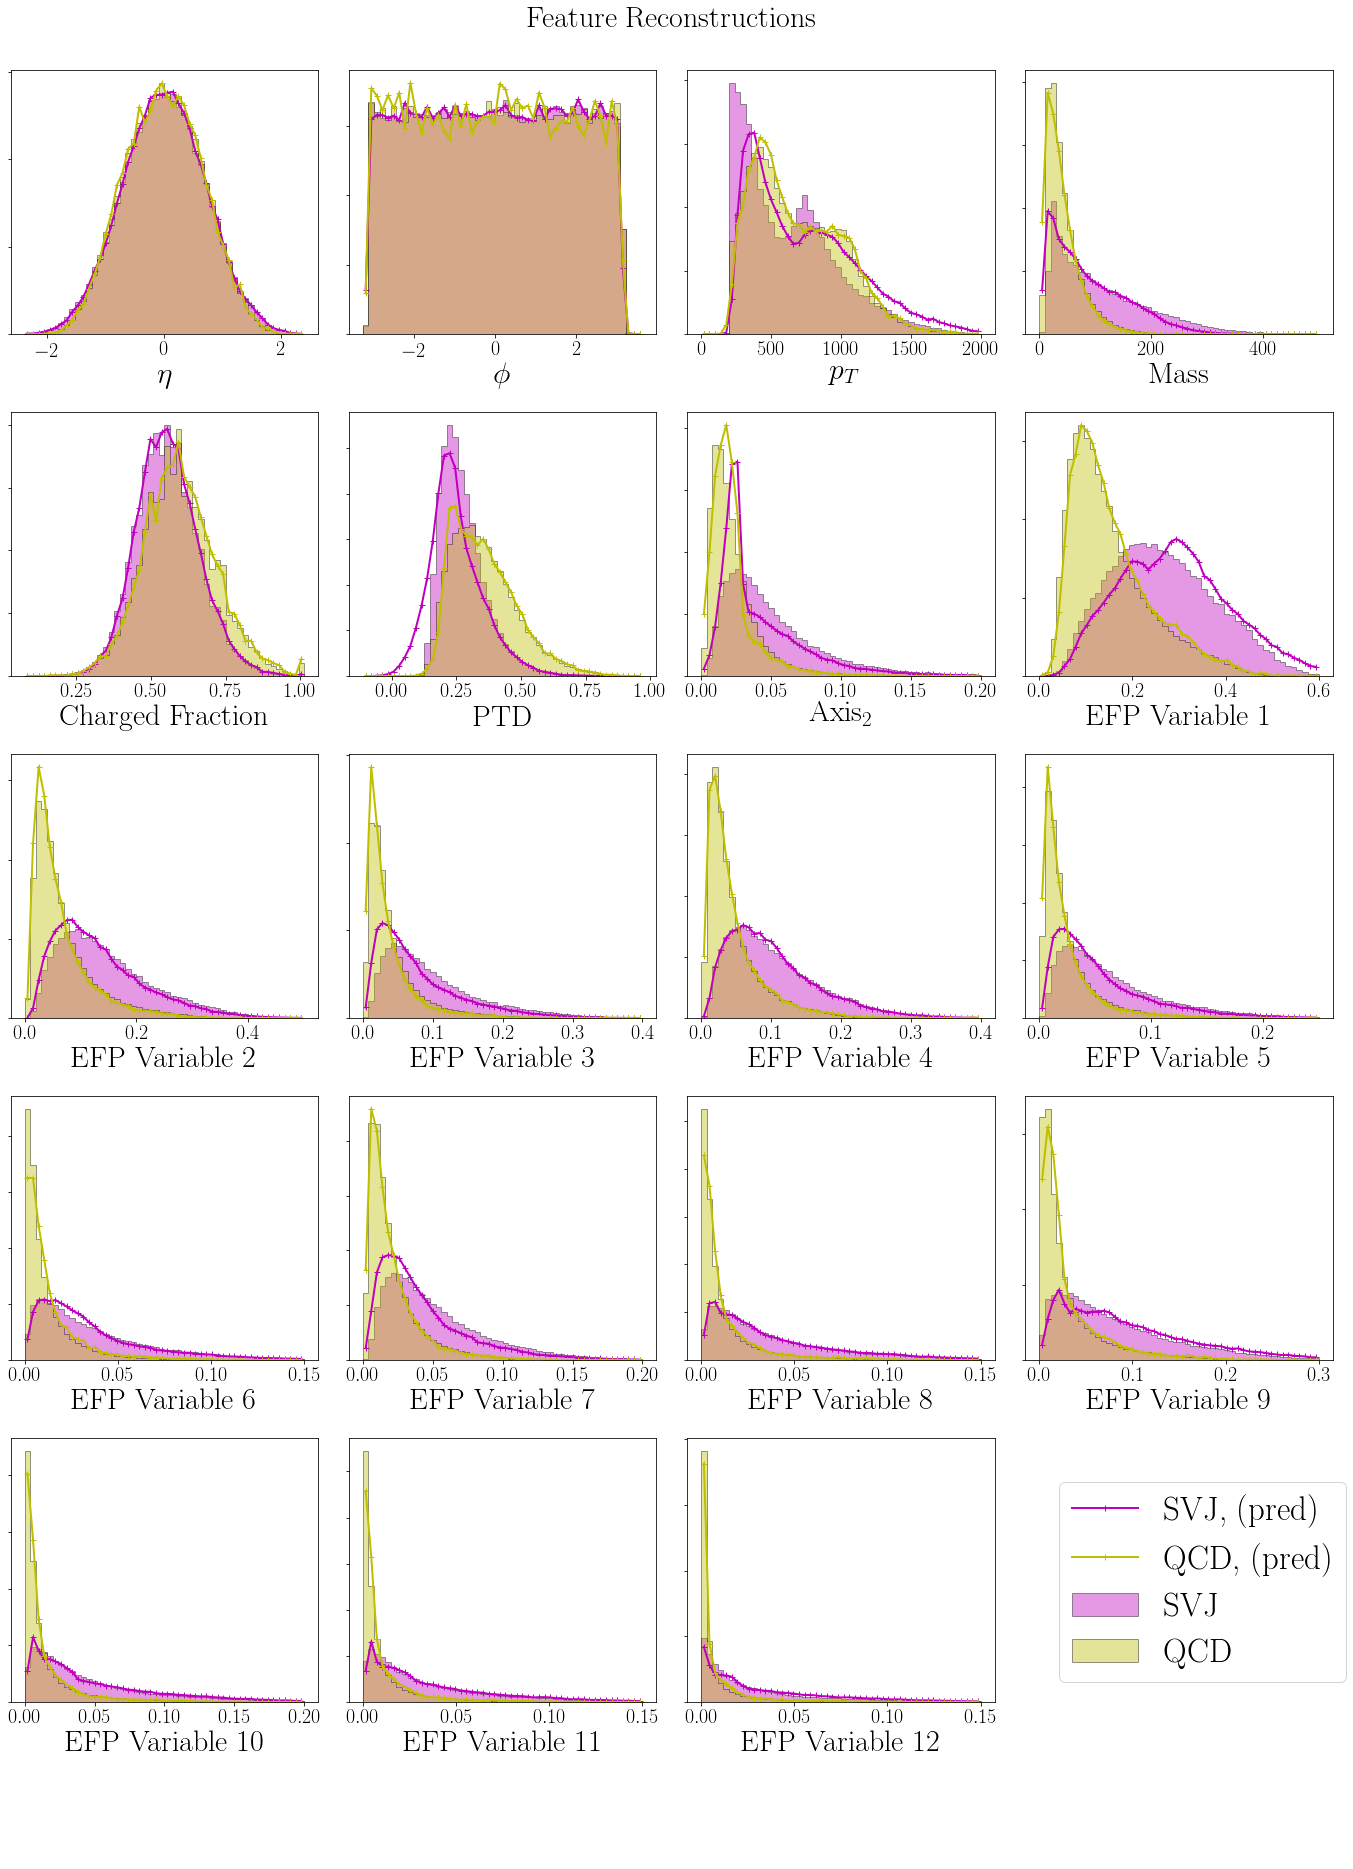

In [205]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': dists['qcd']
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 19./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        var_style['fontsize'] = 30
        ax.set_xlabel(**(var_style))
        
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        ax.set_yticklabels([])

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

[2698,
 1492,
 1361,
 223,
 822,
 2392,
 2650,
 2757,
 1643,
 41,
 2011,
 1388,
 1258,
 47,
 607,
 1108,
 1137,
 2736,
 1400,
 2728,
 2089,
 1452,
 82,
 2394,
 862,
 2467,
 2270,
 398,
 2674,
 1330,
 1817,
 1070,
 2109,
 2611,
 16,
 475,
 901,
 1083,
 909,
 638,
 1573,
 75,
 386,
 2276,
 144,
 1484,
 2565,
 84,
 2589,
 2585,
 1683,
 1668,
 925,
 402,
 2490,
 163,
 524,
 2138,
 2476,
 1932,
 2142,
 2265,
 1571,
 2526,
 54,
 1169,
 559,
 1016,
 2223,
 2383,
 2186,
 53,
 1191,
 2389,
 59,
 1060,
 759,
 1650,
 1365,
 2073,
 1054,
 1435,
 643,
 2477,
 786,
 1117,
 2227,
 1020,
 1417,
 331,
 29,
 1864,
 447,
 405,
 2034,
 2750,
 431,
 1460,
 1680,
 256,
 1737,
 1531,
 549,
 1453,
 922,
 1160,
 921,
 2166,
 1146,
 2464,
 802,
 944,
 1293,
 920,
 2661,
 2004,
 288,
 2202,
 2528,
 799,
 321,
 889,
 2628,
 219,
 1418,
 1069,
 1589,
 718,
 2475,
 79,
 665,
 1620,
 2412,
 2347,
 1462,
 2430,
 1548,
 1032,
 1519,
 2724,
 2660,
 2239,
 1014,
 1603,
 1979,
 845,
 477,
 1188,
 1974,
 1545,
 1280,
 211

In [224]:
help(random.choice)

Help on method choice in module random:

choice(self, seq) method of random.Random instance
    Choose a random element from a non-empty sequence.



In [328]:
se_idx = random.sample(list(set(signal_err.index)), 2500)
signal_err.loc[se_idx].shape

(75000, 2)

In [329]:
75000/2500

30

In [334]:
len(errors['qcd'])/30

517

(119570, 2)

In [410]:
data['mae'].keys()

['Z', 'qcd']

Text(0,0.5,u'Count')

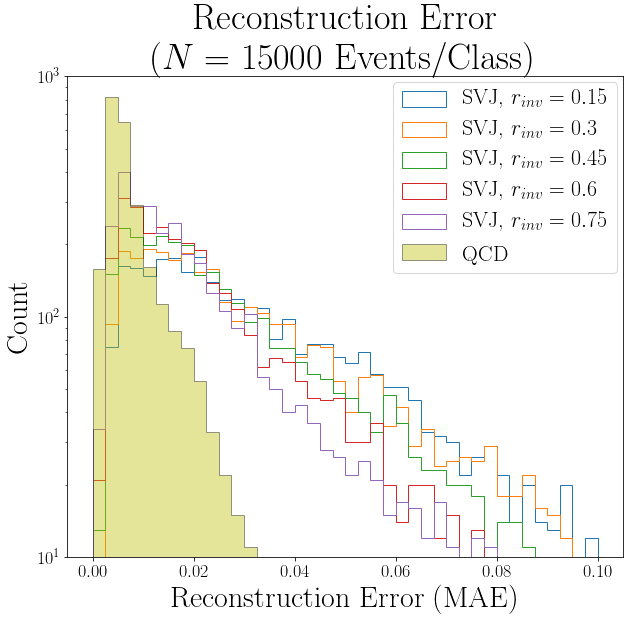

In [521]:
N = 15000

keys = errors.keys()
keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N//30)

newdata = {}
for nu, gp in keys.groupby('nu').key:
     newdata[nu] = pd.concat([errors[k].df.loc[se_idx] for k in gp])
    
N = 15000

# se_idx = random.sample(list(set(signal_err.index)), N//30)
qe_idx = random.sample(range(len(errors['qcd'])), N//6)

inp = {'qcd': errors['qcd'].iloc[qe_idx]}
inp.update(newdata)
data = converter(inp)
data.pop('mse')
bins=40
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=(0, 0.10)

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

stack = []
for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        if k in styles:
            style = styles[k].copy()
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
        else:
            ax.hist(datum, range=rng,bins=nbins, normed=normed, label=r'SVJ, $r_{inv} = ' + '{}$'.format(str(k)), histtype='step')
            stack.append(np.histogram(datum, range=rng, bins=nbins, normed=normed))
            
        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e3)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.62,.56), fontsize=22)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N))
plt.ylabel('Count')



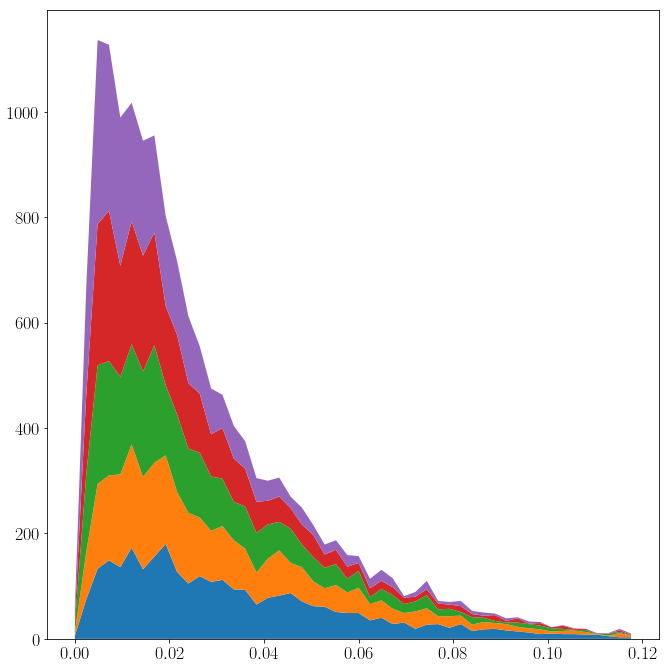

In [453]:
plt.stackplot(stack[0][1][:-1], *np.asarray(stack)[:,0].tolist(), alpha=1)

0.267902073325


Text(0,0.5,u'Count')

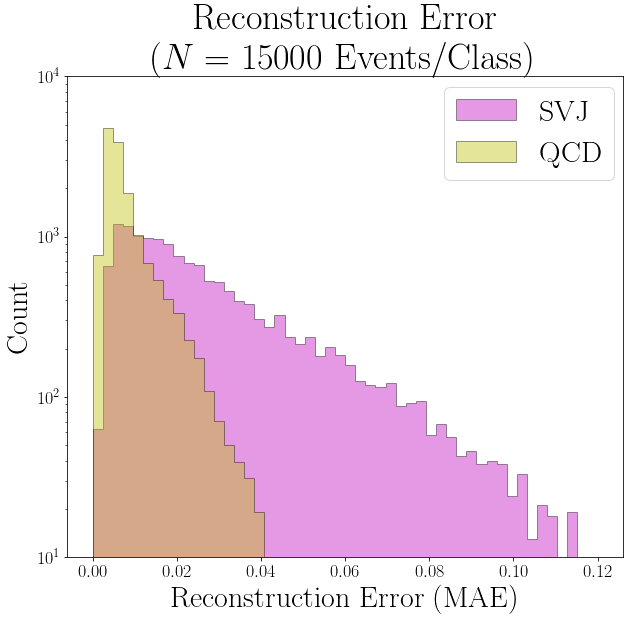

In [398]:
N = 15000

se_idx = random.sample(list(set(signal_err.index)), N//30)
qe_idx = random.sample(range(len(errors['qcd'])), N)
data = converter({'Z': signal_err.loc[se_idx], 'qcd': errors['qcd'].iloc[qe_idx]})
data.pop('mse')
print(data['mae']['Z'].max())
bins=50
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=(0, 0.12)
split=True

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)

        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7,.71), fontsize=30)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N))
plt.ylabel('Count')



In [292]:
# from matplotlib import lines as mplines


# lone = agetter.get_aucs(err={v.name: v for v in [errors['qcd'], signal_err]})

# # errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

# prop_cycle = plt.rcParams['axes.prop_cycle']
# all_colors = prop_cycle.by_key()['color']
# all_lines = ['-', '--', '-.', ':', '-']
# all_markers = ['x', 'o', 'd', '1', 's', '*']
# # all_lines = ["s", "o", "d", "x", "1"]
# aucplot = lone.copy()

# masses, nus = map(set, np.asarray([[a.split('_')[1], '{:.2f}'.format(int(a.split('_')[2])/100.)] for a in aucplot.keys()]).T)
# colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
# lines = {nu: '-' for i,nu in enumerate(nus)}
# # markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

# plt.figure(figsize=(10,10))

# used_labels = set()
# for a in aucplot:
#     for typ in aucplot[a]:
# #         mass,nu = a.split('_')[1:]
# #         nu = '{:.2f}'.format(int(nu)/100.)
#         roc = aucplot[a][typ]['roc']
#         auc = aucplot[a][typ]['auc']
#         lab = None
# #         lab = r'${}$'.format(nu)
# #         if lab in used_labels:
# #             lab = None
# #         used_labels.add(lab)
#         plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=r'$Z^+$ Dark (Avg.): AUC {:.4f}'.format(auc)) 
#     #, label=r'${}$, Nu={}'.format(mass, nu))
# plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Signal Discrimination ROC Curve')
# # plt.yscale('log')
# # plt.xscale('log')
# plt.legend()
# # plt.ylim(1e-1, 1)
# # plt.xlim(1e-3, 1)

# plt.show()

In [281]:
aubplot

NameError: name 'aubplot' is not defined

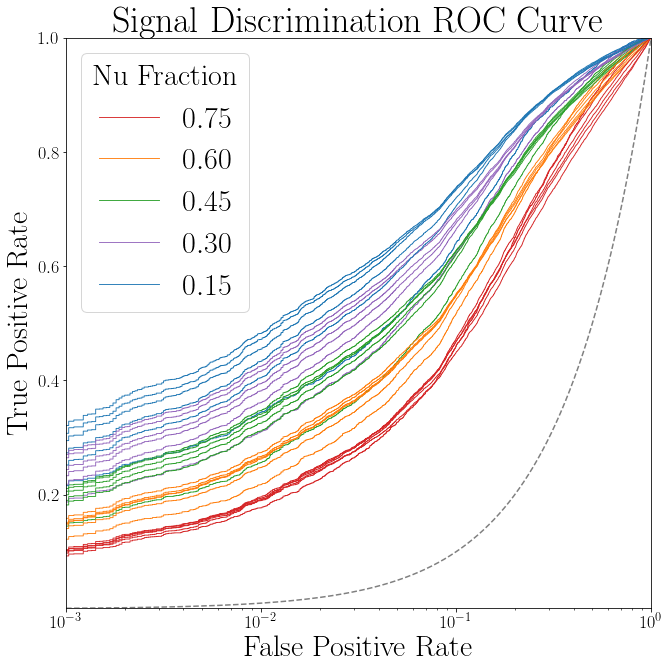

In [289]:
from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

prop_cycle = plt.rcParams['axes.prop_cycle']
all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

plt.figure(figsize=(10,10))
aucplot = aucs_.copy()

dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mae']['roc'][1][np.argmin(abs(v['mae']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]
i = 0 

used_labels = set()
used_styles = OrderedDict()
for a in aucplot:
    for typ in aucplot[a]:
        mass,nu = a.split('_')[1:]
        nu = '{:.2f}'.format(int(nu)/100.)
        roc = aucplot[a][typ]['roc']
        auc = aucplot[a][typ]['auc']
        
        lab = r'${}$'.format(nu)
        if lab in used_labels:
            lab = None
        used_labels.add(lab)
        
        
#         nex = dots[index[i]]
        idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
        nex = 2e-3
#         xplt = np.argmin(abs(roc[0] - nex))
        i += 1 
        
        plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=lab, linewidth=0.9) 
        used_styles[(nu, mass)] = plt.plot(roc[0][idxs], roc[1][idxs], marker=None,#markers[mass],
                                           markeredgecolor=colors[nu], markerfacecolor='None',
                                           markersize=6, linestyle='None'
                                          )
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
# plt.yscale('log')#
plt.xscale('log')
plt.legend(title='Nu Fraction')
plt.ylim(1e-3, 1)
plt.xlim(1e-3, 1)

plt.show()

In [ ]:
df = pd.DataFrame({k: v['mae'] for k,v in aucplot.items()}).T['auc'].to_frame()
df['nu'] = [int(x.split('_')[2])/100. for x in df.index.values]
df['mass'] = [int(x.split('_')[1].rstrip('GeV')) for x in df.index.values]
df = df.pivot('mass', 'nu', 'auc')

In [ ]:
qcd_mae = (agetter.get_test_dataset(dholder).df - recon['qcd pred'].df).abs()
signal_mae = (signal.df - signal_recon.df).abs()

In [ ]:
utils.data_table(qcd_mae, name='qcd').plot(utils.data_table(signal_mae, name='signal'), normed=1, bins=100, xscale='log')